In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from nltk.stem.porter import PorterStemmer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup

from tqdm import tqdm
import os
# fix random seed for reproducibility
np.random.seed(7)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# using the SQLite Table to read data.
#os.chdir(r"C:\Users\Bazinga\AAIC\Assignments\AmazonDBSqlite")
os.chdir(r'/content/drive/My Drive/AI/AmazonDBSqlite/')
con = sqlite3.connect('database.sqlite') 

In [4]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [6]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [7]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [8]:
display['COUNT(*)'].sum()

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [18]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    preprocessed_reviews.append(sentance.strip().split())

100%|██████████| 87773/87773 [00:42<00:00, 2055.02it/s]


In [19]:
preprocessed_reviews[1200]

['little',
 'sugar',
 'bees',
 'hit',
 'cake',
 'cute',
 'addition',
 'winnie',
 'pooh',
 'cake',
 'love',
 'packed',
 'would',
 'not',
 'break',
 'would',
 'definitely',
 'order']

In [20]:
x_train_data, x_test_data, y_train, y_test = train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state = 45)

In [21]:
# find all unique words in corps, sort them using occurance and index each word
top_words=5000
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(x_train_data)

words_to_index_train = tokenizer.word_index

In [22]:
x_train_seq=tokenizer.texts_to_sequences(x_train_data)

In [23]:
#tokenizing test and train data seperately to ensure test and train data isolation
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(x_test_data)

words_to_index_test = tokenizer.word_index

In [24]:
x_test_seq=tokenizer.texts_to_sequences(x_test_data)

In [25]:
max(np.max(x_train_seq))

4998

In [26]:
print(x_train_seq[10])

[5, 412, 126, 366, 1433, 2134, 996, 2, 126, 366, 508, 963, 14, 189, 37, 233, 16, 96, 412, 1625, 2842, 21, 832, 222, 1766, 52, 192, 705]


In [27]:
print(x_train_data[10])

['great', 'alternative', 'regular', 'soda', 'sense', 'aside', 'carbonated', 'like', 'regular', 'soda', 'contains', 'vitamins', 'no', 'added', 'sugar', 'making', 'really', 'healthy', 'alternative', 'sparkling', 'appearance', 'also', 'adds', 'attraction', 'juice', 'downside', 'think', 'expensive', 'satisfying']


In [28]:
print(words_to_index_train.get('great'))
print(words_to_index_train.get('alternative'))
print(words_to_index_train.get('regular'))

5
412
126


In [29]:
# truncate and/or pad input sequences
from keras.preprocessing import sequence
max_review_length = 200
x_train = sequence.pad_sequences(x_train_seq, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test_seq, maxlen=max_review_length)

In [30]:
print(x_train.shape)
print(x_train[1])

(61441, 200)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  540 1859   67  108 1466
   54 2579  799 1556  183    1  336  809  676 2456   14 4633  111   55
  900  294 4750  237 4634  839   86  753  112  249   31  611   39   57
   41 1031  232   86   13 1466  176  305   34  982  205 1633 1786  659
 3056  726  128   71   38   13  546 1028   14  199  273 1067   7

In [31]:
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [32]:
print(y_train.shape)
print(y_train[1])

(61441,)
1


In [33]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
def plt_dynamic(x, vy, ty, ax, x1_label, x2_label, color=['b']):
    ax.plot(x, vy, 'b', label=x1_label)
    ax.plot(x, ty, 'r', label=x2_label)
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## LSTM on Amazon Fine Food Reviews

### a. Single LSTM layer

In [36]:
from keras.layers.normalization.batch_normalization import BatchNormalization
# create the model
embedding_vecor_length = 32
epochs=10
model1 = Sequential()
model1.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model1.add(LSTM(84, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))


In [37]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
history=model1.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           160000    
                                                                 
 lstm_1 (LSTM)               (None, 200, 84)           39312     
                                                                 
 lstm_2 (LSTM)               (None, 84)                56784     
                                                                 
 dense_1 (Dense)             (None, 1)                 85        
                                                                 
Total params: 256,181
Trainable params: 256,181
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
961/961 [==============================] - 26s 23ms/step - loss: 0.2449 - accuracy: 0.9022 - val_loss: 0.5224 - val_accuracy: 0.7885
Epoch 2/10
961/961 [===========

In [39]:
y_pred=model1.predict(x_test, batch_size=24)
y_pred=np.round(y_pred)

Test score: 1.145105004310608
Test accuracy: 0.775634229183197


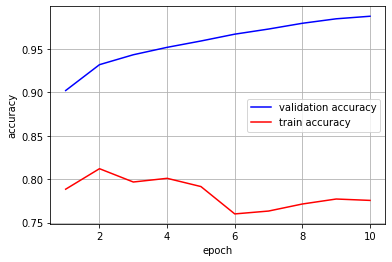

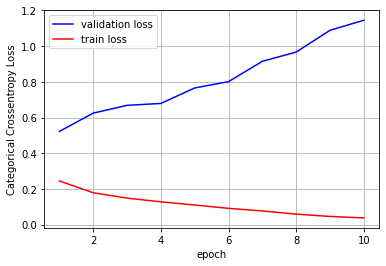

In [41]:
score = model1.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('accuracy')

x = list(range(1,epochs+1))
x1_label='validation accuracy'
x2_label='train accuracy'
vy = history.history['accuracy']
ty = history.history['val_accuracy']
plt_dynamic(x, vy, ty, ax, x1_label, x2_label)


fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x1_label='validation loss'
x2_label='train loss'
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, x1_label, x2_label)

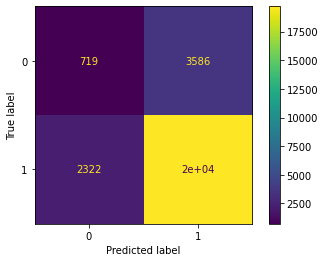

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_disp=ConfusionMatrixDisplay(cm)
cm_disp.plot()

### b. Two LSTM layers

In [43]:
# create the model
embedding_vecor_length = 50
epochs=10
model2 = Sequential()
model2.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model2.add(LSTM(128, return_sequences=True))
model2.add(Dropout(0.8))
model2.add(LSTM(128))

model2.add(Dense(2, activation='sigmoid'))


In [44]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())
history=model2.fit(x_train, y_train, epochs=epochs, batch_size=64, validation_data=(x_test, y_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           250000    
                                                                 
 lstm_3 (LSTM)               (None, 200, 128)          91648     
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 473,361
Trainable params: 473,361
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
961/961 [=======================

In [46]:
y_pred=model2.predict(x_test, batch_size=24)
y_pred=np.round(y_pred)

Test score: 1.0272867679595947
Test accuracy: 0.7544812560081482


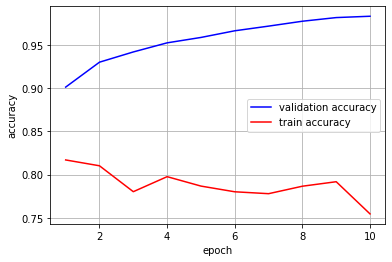

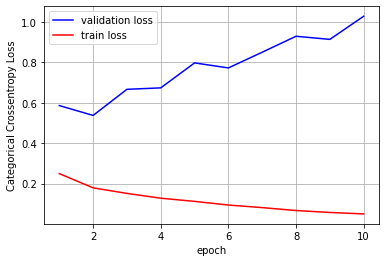

In [50]:
score = model2.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('accuracy')

x = list(range(1,epochs+1))
x1_label='validation accuracy'
x2_label='train accuracy'
vy = history.history['accuracy']
ty = history.history['val_accuracy']
plt_dynamic(x, vy, ty, ax, x1_label, x2_label)


fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

x1_label='validation loss'
x2_label='train loss'
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax, x1_label, x2_label)

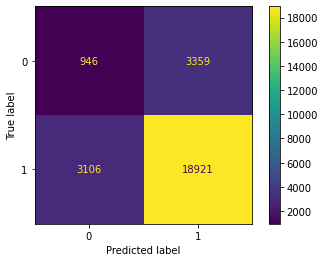

In [49]:
cm = confusion_matrix(y_test, y_pred)
cm_disp=ConfusionMatrixDisplay(cm)
cm_disp.plot()